# Solving the Facility Location Problem with **Multi-Objective** Bayesian Optimization

## Preparation

In [1]:
import random
import numpy as np
import scipy as sp
import torch
import polars as pl
from tqdm import tqdm
from matplotlib import pyplot as plt

from subset_bo import get_next_query_by_mo, solve_by_mip

/mnt/d/repos/set_bbo/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# random seed
SEED = 123

# minimum and maximum number of facilities
TARGET_SIZE_MIN = 3
TARGET_SIZE_MAX = 7

# beam width for beam search
BEAM_WIDTH = 5

# number of queries
NUM_TRY = 100

In [3]:
# set random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Generate facility location candidates and delivery location set

In this notebook, we generate facility location candidates randomly, and delivery locations are equals to the facility location candidates.

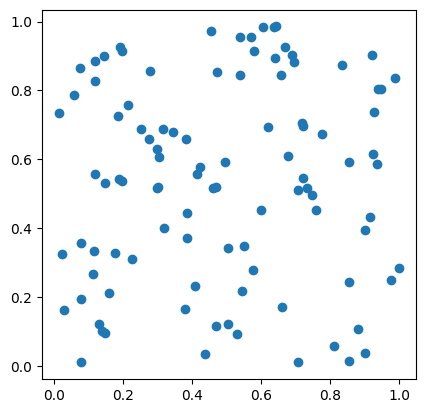

In [4]:
features = torch.rand(size=(100, 2))

plt.scatter(features[:, 0], features[:, 1])
plt.gca().set_aspect('equal')
plt.show()

## Objective Function

In [5]:
def obj(x: list[int]):
    assert len(x) == len(features)
    x = np.array(x)
    idx = np.nonzero(x)[0]
    centers = features[idx, :]
    dists = sp.spatial.distance_matrix(centers, features)
    return float(dists.min(axis=0).sum())

## Generate initial training data

We generate single random data for each number of facilities.

In [6]:
train_x = []
for n in range(TARGET_SIZE_MIN, TARGET_SIZE_MAX + 1):
    tmp = random.sample(range(len(features)), n)
    tmp_x = [0 for _ in range(len(features))]
    for i in tmp:
        tmp_x[i] = 1
    train_x.append(tmp_x)
train_x = torch.Tensor(train_x).to(dtype=torch.float64)

train_y = [
    obj(x.tolist())
    for x in train_x
]
train_y = torch.Tensor(train_y).reshape(-1, 1).to(train_x)

## Optimization

In [7]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06."
)

In [8]:
history = []

for t in tqdm(range(NUM_TRY)):
    next, next_acqfval = get_next_query_by_mo(
        features=features,
        train_x=train_x,
        train_y=train_y,
        min_num=TARGET_SIZE_MIN,
        max_num=TARGET_SIZE_MAX,
        beam_width=BEAM_WIDTH,
    )

    observed = obj(next)

    train_x = torch.cat([train_x, torch.Tensor(next).reshape(1, -1).to(train_x)])
    train_y = torch.cat([train_y, torch.Tensor([[observed]]).to(train_x)])

    info = {
        "t": t,
        "try_x": next,
        "try_acqfval": next_acqfval,
        "try_obs": observed
    }
    history.append(info)

100%|██████████| 100/100 [01:12<00:00,  1.39it/s]


In [9]:
df = pl.DataFrame(history)
df = df.with_columns(try_len=pl.col("try_x").map_elements(lambda x: int(sum(x)), return_dtype=int))


## Get optiamal solutions by MIP solver

To evaluate the performance of Bayesian optimization, we get the optimal solution by MIP solver.

In [10]:
opt_res = []
for n in range(TARGET_SIZE_MIN, TARGET_SIZE_MAX + 1):
    tmp_obj, tmp_sol = solve_by_mip(features, n)
    opt_res.append({
        "n": n,
        "obj": tmp_obj,
        "center_idx": tmp_sol
    })
opt_res = pl.DataFrame(opt_res)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /mnt/d/repos/set_bbo/.venv/lib/python3.11/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/c5ec4acc46994718bca963728014b41d-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/c5ec4acc46994718bca963728014b41d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 10106 COLUMNS
At line 70307 RHS
At line 80409 BOUNDS
At line 90510 ENDATA
Problem MODEL has 10101 rows, 10100 columns and 30100 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 22.9284 - 0.32 seconds
Cgl0004I processed model has 10101 rows, 10100 columns (10100 integer (10100 of which binary)) and 30100 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 22.9284
Cbc0038I Before mini branch and bound, 10100 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound di

Compare the performance of Bayesian optimization with the optimal solution.

In [11]:
df.group_by(pl.col("try_len")).agg(pl.col("try_obs").min()).sort("try_len").join(
    opt_res.select(["n", "obj"]),
    left_on="try_len", right_on="n",
    how="inner"
).rename({
    "try_len": "# of facilities",
    "try_obs": "BO",
    "obj": "Optimal"
}).with_columns(
    relative_perf=pl.col("BO") / pl.col("Optimal")
)

shape: (5, 4)
┌─────────────────┬───────────┬───────────┬───────────────┐
│ # of facilities ┆ BO        ┆ Optimal   ┆ relative_perf │
│ ---             ┆ ---       ┆ ---       ┆ ---           │
│ i64             ┆ f64       ┆ f64       ┆ f64           │
╞═════════════════╪═══════════╪═══════════╪═══════════════╡
│ 3               ┆ 23.20735  ┆ 22.928411 ┆ 1.012166      │
│ 4               ┆ 19.735505 ┆ 18.828088 ┆ 1.048195      │
│ 5               ┆ 16.993244 ┆ 16.172342 ┆ 1.05076       │
│ 6               ┆ 15.545611 ┆ 14.249529 ┆ 1.090956      │
│ 7               ┆ 13.694893 ┆ 12.512592 ┆ 1.094489      │
└─────────────────┴───────────┴───────────┴───────────────┘

## Visualization

### Optimization Progress

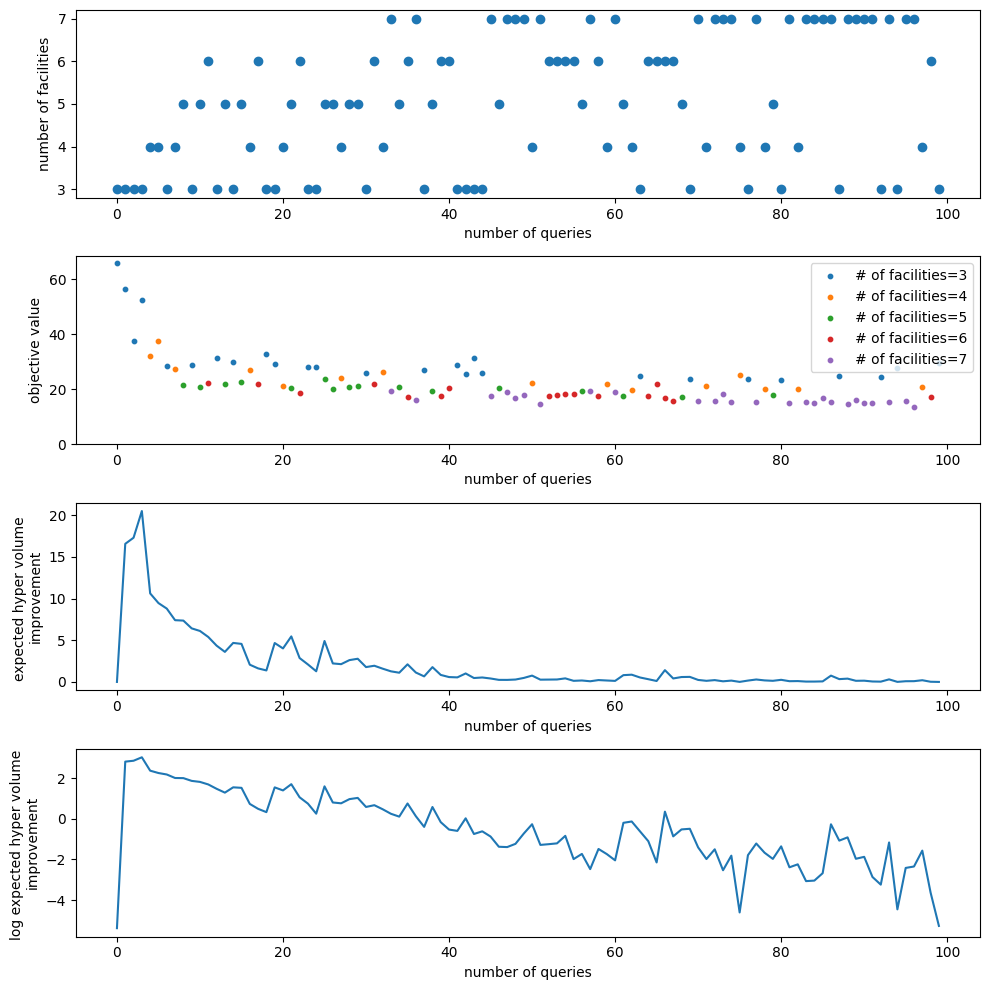

In [12]:
fig, ax = plt.subplots(4, 1, figsize=(10, 10))

ax[0].scatter(df["t"], df["try_len"], label="len")
ax[0].set_xlabel("number of queries")
ax[0].set_ylabel("number of facilities")

for n in range(TARGET_SIZE_MIN, TARGET_SIZE_MAX + 1):
    tmp_sub_df = df.filter(pl.col("try_len") == n)
    ax[1].scatter(tmp_sub_df["t"], tmp_sub_df["try_obs"], label=f"# of facilities={n}", s=10)
    ax[1].legend(loc="upper right")
    ax[1].set_xlabel("number of queries")
    ax[1].set_ylabel("objective value")
ax[1].set_ylim(bottom=0)

ax[2].plot(df["t"], df["try_acqfval"].exp(), label="EHVI")
ax[2].set_xlabel("number of queries")
ax[2].set_ylabel("expected hyper volume \nimprovement")

ax[3].plot(df["t"], df["try_acqfval"], label="logEHVI")
ax[3].set_xlabel("number of queries")
ax[3].set_ylabel("log expected hyper volume \nimprovement")

plt.tight_layout()
plt.show()

## Number of facilities vs. Objective Value

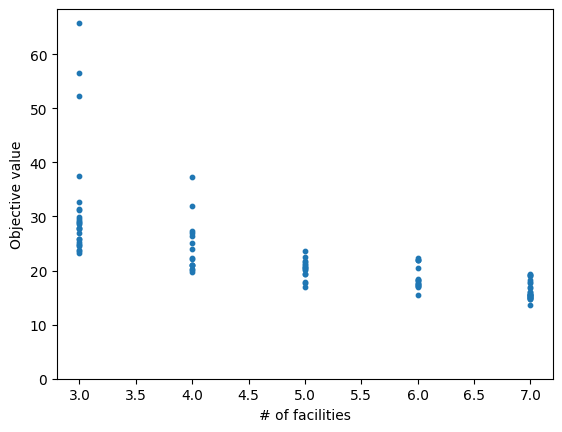

In [13]:
plt.scatter(df["try_len"], df["try_obs"], s=10)
plt.xlabel("# of facilities")
plt.ylabel("Objective value")
plt.gca().set_ylim(bottom=0)
plt.show()

### Animation of Optimization Process

The blue points are the queried points, and the red points are the best points so far, the gray points are the customers.

In [14]:
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
ax.set_aspect('equal')

artists = []
for t in range(df.shape[0]):
    s1 = ax.scatter(features[:, 0], features[:, 1], c="gray", alpha=0.3, label="candidates")
    try_idx = np.array(df["try_x"][t]).nonzero()[0]
    s3 = ax.scatter(features[try_idx, 0], features[try_idx, 1], c="blue", marker="x", s=50, label="tried")

    try_obj = df["try_obs"][t]
    t1 = ax.text(0.1, 1.1, f"{t=: 2}, # of facilities: {df['try_len'][t]}, Objective value={try_obj: 3.3f}")
    artists.append([s1, s3, t1])

anim = ArtistAnimation(fig, artists, interval=1000)
plt.close()
HTML(anim.to_jshtml())

### Best Solution of Each Number of Facilities

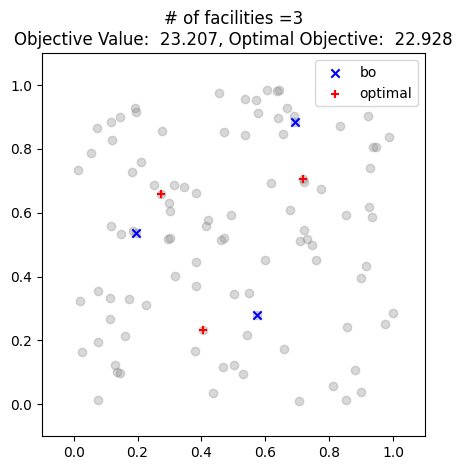

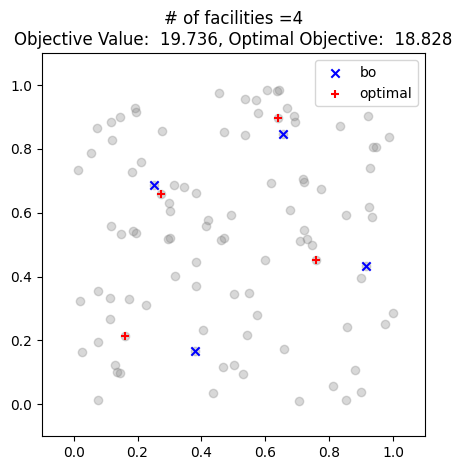

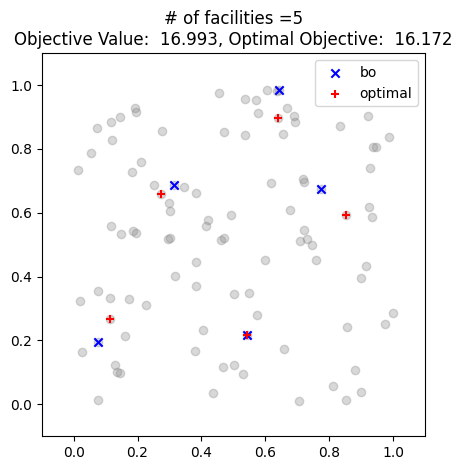

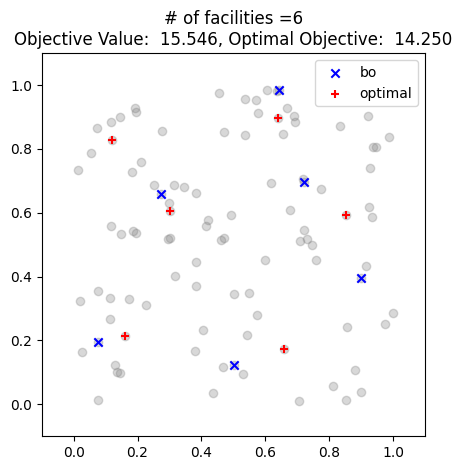

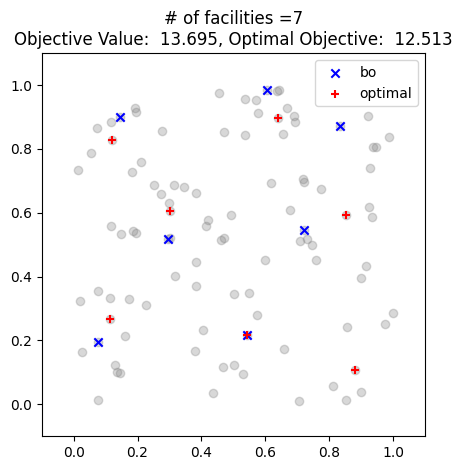

In [15]:
for n in range(TARGET_SIZE_MIN, TARGET_SIZE_MAX + 1):
    best_val = df.filter(pl.col("try_len") == n)["try_obs"].min()
    best_x = np.array(df.filter((pl.col("try_len") == n) & (pl.col("try_obs") == best_val))["try_x"][0].to_list())
    best_idx = best_x.nonzero()[0]

    opt_idx = opt_res.filter(pl.col("n") == n)["center_idx"][0]
    opt_val = opt_res.filter(pl.col("n") == n)["obj"][0]

    plt.figure()
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.gca().set_aspect('equal')
    plt.scatter(features[:, 0], features[:, 1], c="gray", alpha=0.3)
    plt.scatter(features[best_idx, 0], features[best_idx, 1], label="bo", c="blue", marker="x")
    plt.scatter(features[opt_idx, 0], features[opt_idx, 1], label="optimal", c="red", marker="+")
    plt.title(f"# of facilities ={n}\nObjective Value: {best_val: 3.3f}, Optimal Objective: {opt_val: 3.3f}")
    plt.legend()
    plt.tight_layout()
    
    plt.show()